<a href="https://colab.research.google.com/github/fitrianrr/magang/blob/main/yh_ini_nyoba_muncul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Project attempt to do topic modeling on 'subject' column

In [ ]:
!pip install -q top2vec
!pip install -q top2vec[sentence_encoders]
!pip install -q bertopic
!pip install -q gensim
!pip install -q pyLDAvis
!pip install -q git+https://github.com/ariaghora/mpstemmer.git
!pip install -q python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from google.colab import drive
from top2vec import Top2Vec
from bertopic import BERTopic
from transformers import AutoModel, AutoTokenizer
import re
from gensim import corpora
from gensim.models import LdaModel
from pprint import pprint
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import pyLDAvis
import pyLDAvis.gensim
from mpstemmer import MPStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel('dataset DLA.xlsx', sheet_name='Data Asli')

In [ ]:
df.head()

,tahun_bulan,tracker,issue_id,done_ratio,created_on,started_on,closed_on,resolved_on,spent_on,day_spent_on,...,project,SUBJECT,state,poin,id_resolver,nama_resolver,grup_resolver,id_creator,nama_creator,ts_jam
0,2024-01,Support,42612,100,2024-01-02 01:53:31,2024-01-02,2024-01-02 04:51:53,2024-01-02 02:24:36,2024-01-02 02:24:36,Tuesday,...,Guru Penggerak,[CF A17] Pengumuman kelulusan Tahap 1 CF A17,Closed,0.5,15,Hamzah Hamzah,DLA,15,Hamzah Hamzah,0.500000
1,2024-01,Support,42617,100,2024-01-02 02:25:38,2024-01-02,2024-01-02 04:51:15,2024-01-02 02:28:29,2024-01-02 02:28:29,Tuesday,...,SIMPATIKA,Deploy perubahan tabel AJUAN_PPG_MIGRASI,Closed,0.5,15,Hamzah Hamzah,DLA,15,Hamzah Hamzah,0.083333
2,2024-01,Support,42661,100,2024-01-02 06:23:20,2024-01-02,2024-01-03 03:06:51,2024-01-02 08:05:13,2024-01-02 08:05:12,Tuesday,...,Sekolah Penggerak,[BI] Update Data BI pada Grup Pendampingan,Closed,1.0,45,Rizky Adi Prasetyo,DLA,45,Rizky Adi Prasetyo,1.000000
3,2024-01,Support,42699,100,2024-01-02 09:23:34,2024-01-02,2024-01-03 07:25:20,2024-01-02 09:26:19,2024-01-02 09:26:19,Tuesday,...,SIMPATIKA,[Bimas Katolik] Perubahan Tanggal Sertifikat N...,Closed,0.5,15,Hamzah Hamzah,DLA,15,Hamzah Hamzah,0.250000
4,2024-01,Support,42740,100,2024-01-03 01:41:49,2024-01-03,2024-01-03 05:54:28,2024-01-03 04:08:01,2024-01-03 04:08:01,Wednesday,...,SIMPATIKA,[Bimas Hindu] Migrasi Data Hasil Seleksi Akade...,Closed,0.5,15,Hamzah Hamzah,DLA,15,Hamzah Hamzah,0.250000


In [ ]:
df = df[df['tracker'] == 'Feature']
docs = df['SUBJECT']

In [ ]:
def rem_stopw(text) :
  listStopword =  set(stopwords.words('indonesian'))
  cleaned = []
  for word in text :
    if word not in listStopword :
      cleaned.append(word)
  return ' '.join(cleaned)

In [ ]:
def clean(text) :
  # convert text to lowercase
  lower_text = text.lower()
  # remove number
  numb_text = re.sub(r"\d+", ' ', lower_text)
  # remove punctuation
  punc_text = numb_text.translate(str.maketrans("","",string.punctuation))

  #remove word that have exacltly 1 character
  processed_text = re.sub(r'\b\w{1}\b', ' ', punc_text)

  cleaned_text = re.sub(r'[【\[][^】\]]*[】\]]', ' ', processed_text)
  # remove stopwords
  no_stopw = rem_stopw(cleaned_text.split())
  # #lemmatize text
  # stemmer = MPStemmer()
  # stemmed_text = stemmer.stem_kalimat(no_stopw)
  return no_stopw

docs_cleaned = docs.apply(clean).tolist()

In [ ]:
docs_cleaned

['build platform otomasi testing respon ai',
 'ml playground prediksi',
 'tambahan penetapan mahasiswa gel januari',
 'tambahan plotting penetapan mahasiswa ppg prajab gelombang',
 'proses migrasi data email belajarid mahasiswa ppg prajabatan gelombang',
 'pemutakhiran master kecamatan simpkb',
 'ml playground prediksi pemilihan dataset',
 'ml playground prediksi pengaturan model',
 'ml playground prediksi visualisasi grafik',
 'ml playground prediksi pengaturan hyperparameter',
 'aplikasi chat sql databases',
 'setup webloyer bi ppdb',
 'setup webloyer laporan kerjasama ppg',
 'setup webloyer tools',
 'ml playground prediksi halaman prediksi',
 'pemutakhiran bi simppg nilai ukmppg',
 'sinkronisasi struktur database simpkb ppg prajab',
 'migrasi data belajarid mahasiswa ppg prajab gelombang',
 'sinkronisasi struktur database simpkb ppg prajab',
 'backup hasil tes diklat ppgkpjok',
 'kolom npsn raw data laporan analitik kelas daring bi',
 'penyediaan api integrasi penambahan akses user 

# Top2Vec

In [ ]:
model = Top2Vec(docs_cleaned)

2024-09-25 00:27:37,720 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2024-09-25 00:27:37,824 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2024-09-25 00:27:50,008 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-09-25 00:27:53,585 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-09-25 00:28:07,968 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2024-09-25 00:28:07,984 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
topic_words, word_scores, topic_nums = model.get_topics()

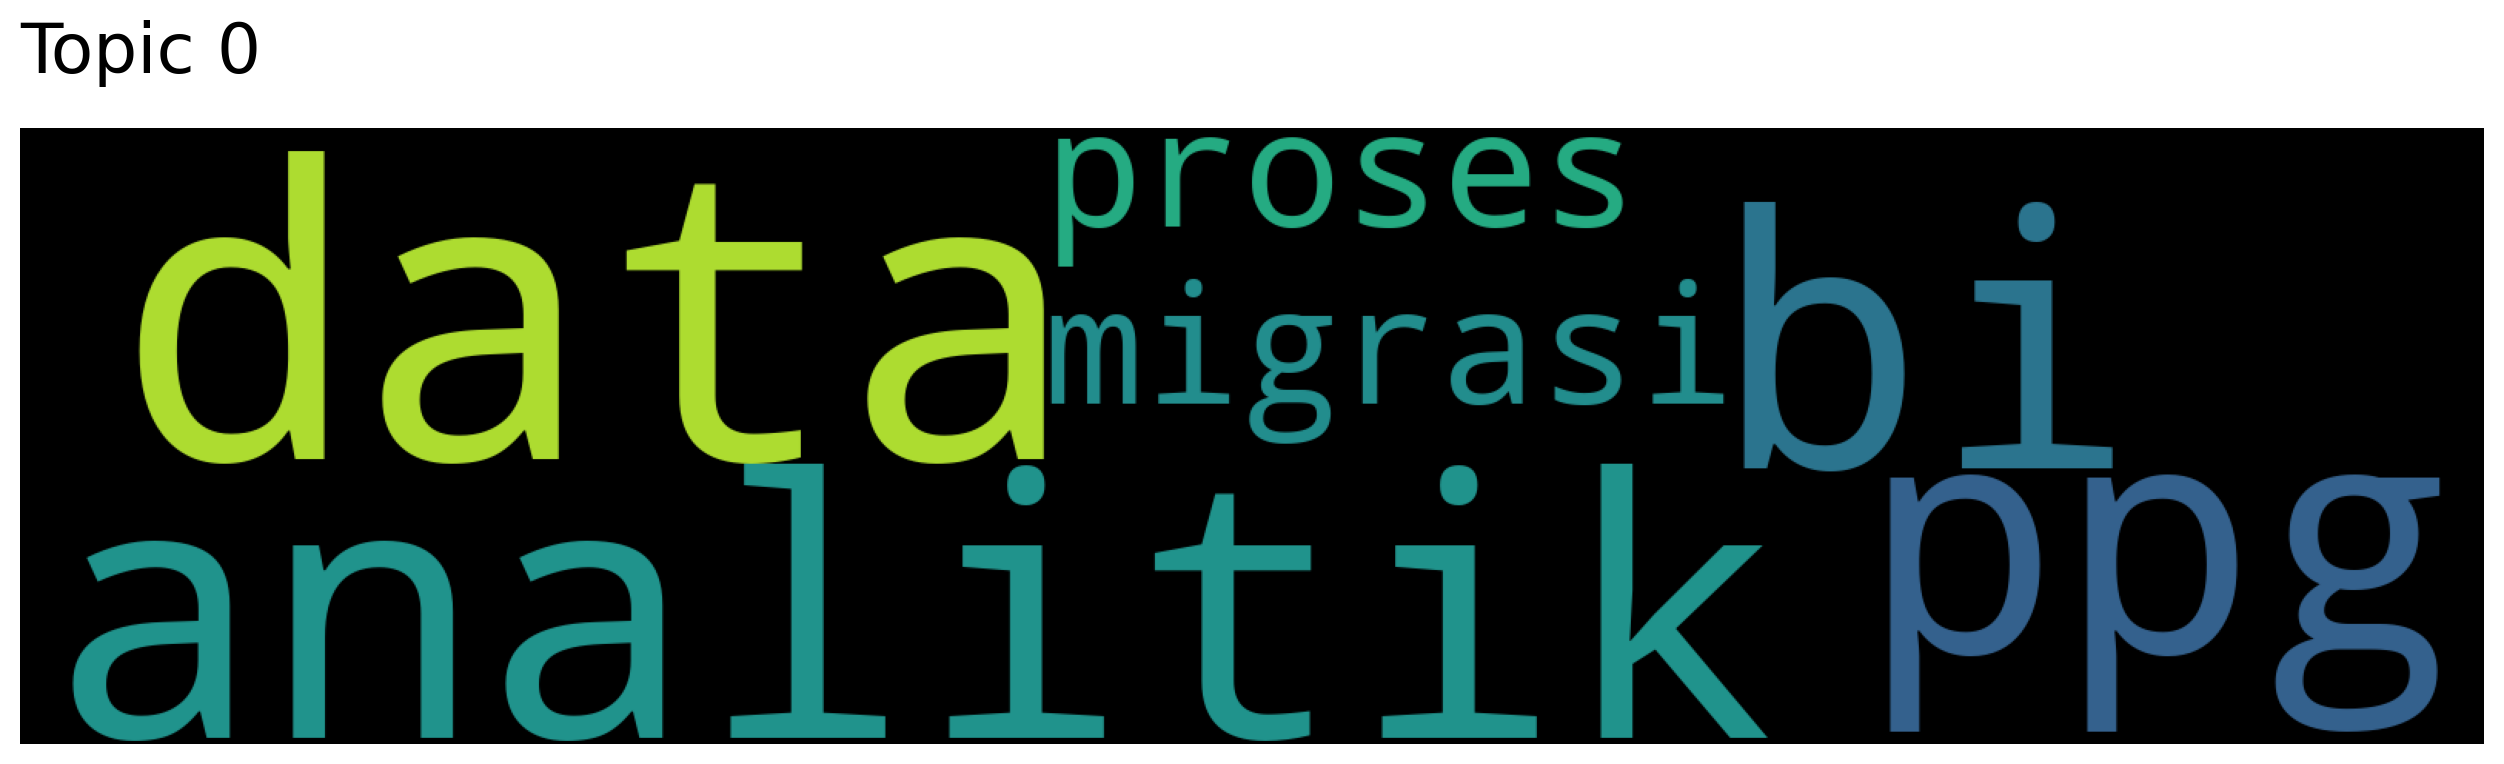

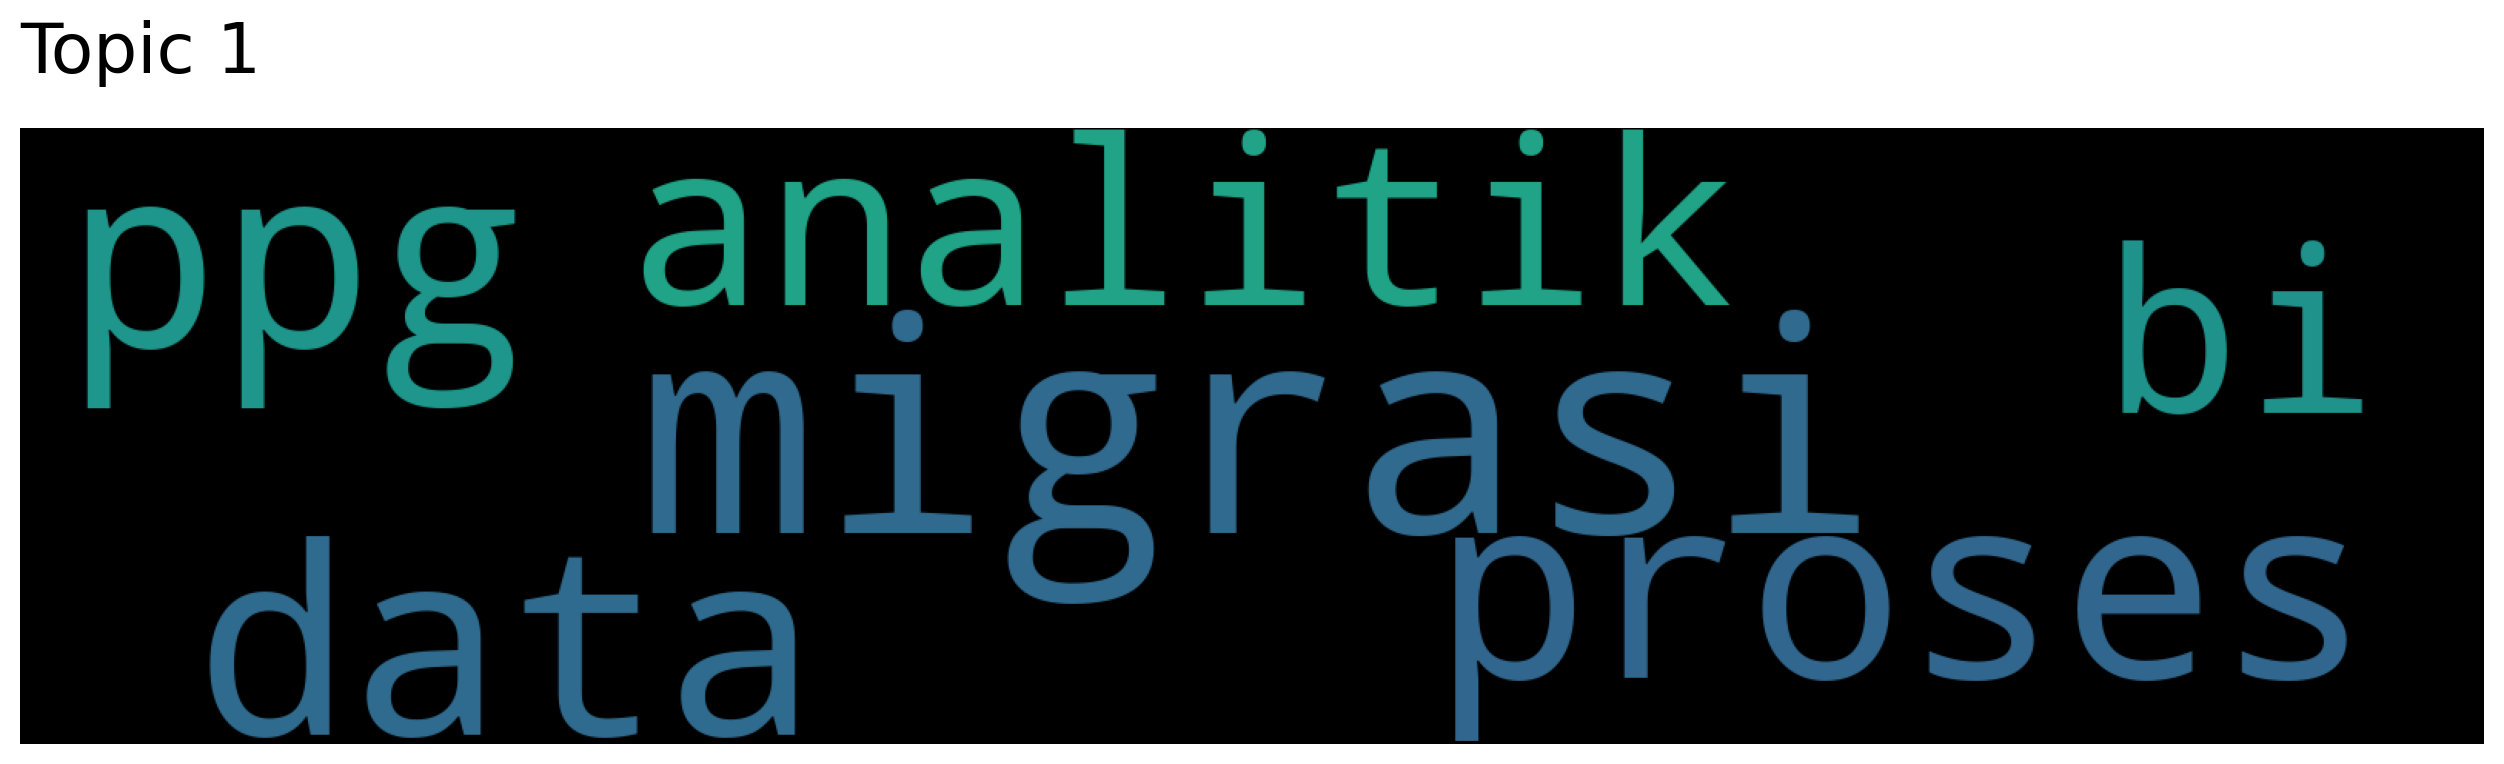

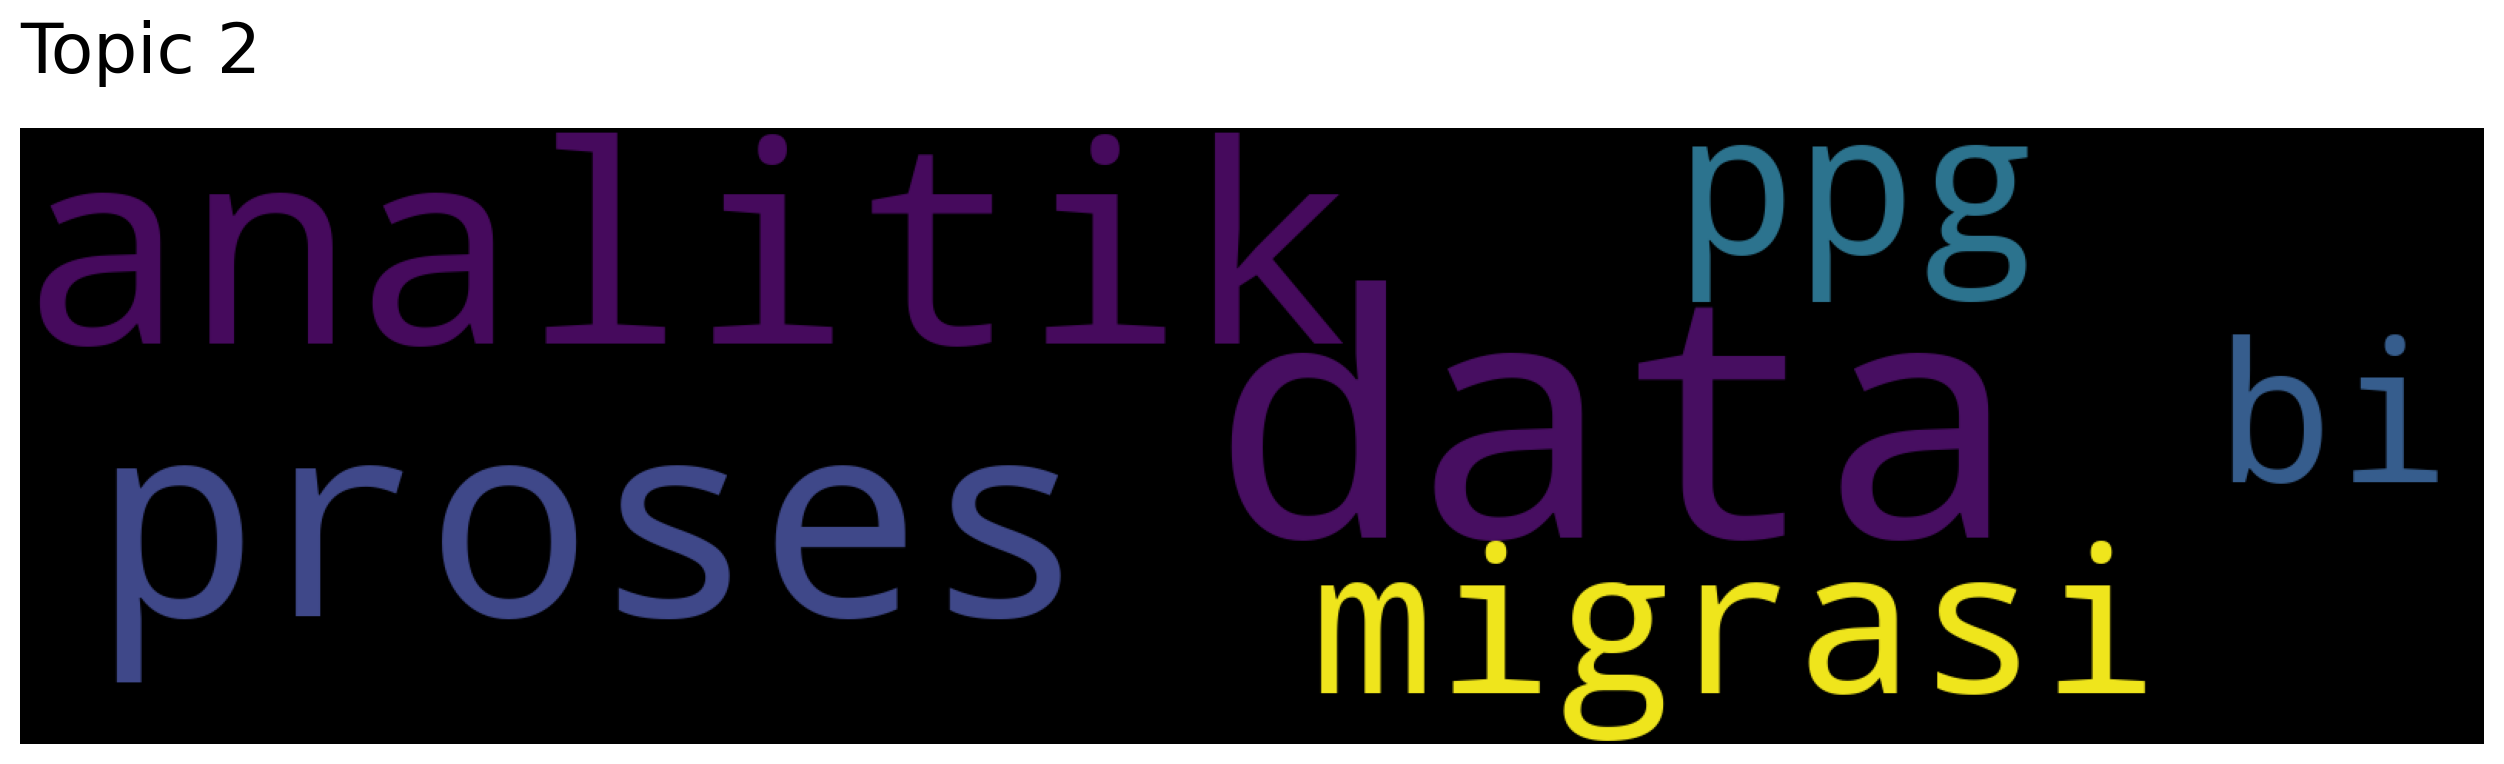

In [ ]:
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

# BERTOPIC


In [ ]:
# Load Indonesian BERT model and tokenizer
model_name = "indolem/indobert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Initialize BERTopic with the custom model
topic_model = BERTopic(embedding_model=model,)
topics, probabilities = topic_model.fit_transform(docs_cleaned)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
print(topic_model.get_topic_info())

# Get the most representative documents for each topic
for topic in topic_model.get_topics():
    print(f"Topic {topic}:")
    for word in topic_model.get_topic(topic):
        print(f"- {word}")

   Topic  Count                           Name  \
0      0    377       0_data_bi_migrasi_proses   
1      1     11  1_filter_penambahan_bi_proses   

                                      Representation  \
0  [data, bi, migrasi, proses, ppg, analitik, dik...   
1  [filter, penambahan, bi, proses, tanggal, lapo...   

                                 Representative_Docs  
0  [pengembangan fewshot analitik data diklat gtk...  
1  [proses penambahan filter laporan pengajar pem...  
Topic 0:
- ('data', 0.11763779162162075)
- ('bi', 0.09404639018778177)
- ('migrasi', 0.07909751016078279)
- ('proses', 0.06974027233689757)
- ('ppg', 0.06770510143533028)
- ('analitik', 0.0640423077011915)
- ('diklat', 0.0600578317828414)
- ('pengembangan', 0.05762312310767383)
- ('asvri', 0.054754717624834165)
- ('bot', 0.05080740893573893)
Topic 1:
- ('filter', 0.5998422931960726)
- ('penambahan', 0.3531848255259592)
- ('bi', 0.30451802545517986)
- ('proses', 0.2122669438483963)
- ('tanggal', 0.1500847964305

# LDA


In [ ]:
# Tokenize the documents
tokenized_docs = [doc.split() for doc in docs_cleaned]
# Create a dictionary mapping each word to a unique id
dictionary = corpora.Dictionary(tokenized_docs)
# Convert tokenized documents into bag-of-words representation
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]
# Train the LDA model
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10, iterations=100)
# Print the topics
pprint(lda_model.print_topics())

[(0,
  '0.049*"data" + 0.039*"proses" + 0.037*"ppg" + 0.036*"migrasi" + 0.035*"bi" '
  '+ 0.020*"prajab" + 0.017*"diklat" + 0.017*"penyediaan" + 0.014*"analitik" + '
  '0.013*"laporan"'),
 (1,
  '0.043*"bi" + 0.030*"pengembangan" + 0.028*"asvri" + 0.026*"analitik" + '
  '0.022*"data" + 0.021*"pjok" + 0.019*"peserta" + 0.018*"diklat" + '
  '0.016*"bot" + 0.013*"nilai"'),
 (2,
  '0.035*"data" + 0.024*"guru" + 0.017*"pengembangan" + 0.014*"migrasi" + '
  '0.013*"prediksi" + 0.012*"simpkb" + 0.012*"bot" + 0.010*"api" + '
  '0.010*"ukkj" + 0.010*"penyediaan"')]


In [ ]:
pyLDAvis.enable_notebook()
lda_vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis_data)